In [393]:
import pandas as pd

In [394]:
import numpy as np

In [395]:
from prophet import Prophet

In [396]:
from sklearn.ensemble import RandomForestRegressor

In [427]:
from sklearn.model_selection import train_test_split

In [397]:
%pip install fredapi
from fredapi import Fred

#### **Load CSV files such as, countyData.csv, nysData.csv, propertyTaxPerCounty10years.csv**

In [398]:
county_data = pd.read_csv('countyData.csv')

In [399]:
nys_data = pd.read_csv('nysData.csv')

In [400]:
tax = pd.read_csv('propertyTaxPerCounty10years.csv')

#### **Load NYSsingleBedCountyDF.csv and NYSsingleFamilyMetroDF.csv**

In [401]:
county_prices = pd.read_csv('NYSsingleBedCountyDF.csv')

In [402]:
metro = pd.read_csv('NYSsingleFamilyMetroDF.csv')

#### **Mortgge rate**

In [403]:
fred = Fred(api_key='bd2983759a4cf1e15823ed3442667fb4') # it's the key from https://fredaccount.stlouisfed.org/apikey
rates = fred.get_series('MORTGAGE30US', observation_start='2015-01-01') #mortgage rate from 2015 to 2025
df_rates = pd.DataFrame(rates, columns=['Mortgage Rate']) # DataFrame for the fred data

#### **Clean Data Metro**

In [404]:
metro_long = metro.melt(id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'],
                        var_name='Date',
                        value_name='HomePrice')

metro_long["Date"] = pd.to_datetime(metro_long["Date"])
metro_long = metro_long.dropna()
metro_long.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,Date,HomePrice
0,394913,1,"New York, NY",msa,NY,2015-01-31,1986.778076
1,394425,50,"Buffalo, NY",msa,NY,2015-01-31,1022.171678
2,395031,52,"Rochester, NY",msa,NY,2015-01-31,1058.697013
3,394308,64,"Albany, NY",msa,NY,2015-01-31,1271.508966
4,845159,86,"Poughkeepsie, NY",msa,NY,2015-01-31,1606.776133


### **Clean COUNTY HOME PRICE DATA**

In [405]:
county_long = county_prices.melt(
    id_vars=["RegionID", "SizeRank", "RegionName", "RegionType", "StateName",
            "State", "Metro", "StateCodeFIPS", "MunicipalCodeFIPS"],
    var_name="PriceDate",
    value_name="HomePrice"
)

county_long["PriceDate"] = pd.to_datetime(county_long["PriceDate"])
county_long = county_long.dropna()


county_long["County"] = county_long["RegionName"].str.replace(" County", "")
county_long["Year"] = county_long["PriceDate"].dt.year
county_long["Month"] = county_long["PriceDate"] + pd.offsets.MonthEnd(0)


### **CLEAN 3 — PROPERTY TAX DATA**

In [406]:
tax_long = tax.melt(id_vars=['County'], var_name='Year', value_name='TaxAmount')
tax_long['TaxDate'] = pd.to_datetime(tax_long['Year'], format='%Y')
tax_clean = tax_long.drop(columns=["Year"])
tax_clean["Year"] = pd.to_datetime(tax_clean["TaxDate"]).dt.year
tax_clean.head()

,County,TaxAmount,TaxDate,Year
0,Albany,3526.0,2015-01-01,2015
1,Allegany,1959.0,2015-01-01,2015
2,Bronx,2653.0,2015-01-01,2015
3,Broome,2417.0,2015-01-01,2015
4,Cattaraugus,2054.0,2015-01-01,2015


#### **CLEAN 4 — COUNTY COST OF LIVING (RENT PROXY)**

In [407]:
county_data["RentDate"] = pd.to_datetime("2024-01-01")
county_rent = county_data[["RentDate", "County", "Housing"]].copy()

# Convert annual housing cost to monthly rent
county_rent["MonthlyRent"] = county_rent["Housing"] / 12

county_rent.head()

,RentDate,County,Housing,MonthlyRent
0,2024-01-01,Albany,13098.0,1091.500000
1,2024-01-01,Allegany,8435.0,702.916667
2,2024-01-01,Bronx,21130.0,1760.833333
3,2024-01-01,Broome,10472.0,872.666667
4,2024-01-01,Cattaraugus,8833.0,736.083333


#### **CLEAN 5 MERGE ALL COUNTY-LEVEL DATA INTO ONE MASTER DATASET**

In [408]:
#Prepare mortgage rate dataframe
df_rates = df_rates.reset_index()
df_rates = df_rates.rename(columns={"index": "RateDate"})
df_rates["RateDate"] = pd.to_datetime(df_rates["RateDate"])

# Convert weekly mortgage data to monthly average
df_rates = df_rates.resample("M", on="RateDate").mean().reset_index()

# Align county home price dates to month-end
county_long["Month"] = county_long["PriceDate"] + pd.offsets.MonthEnd(0)

# Make RateDate == Month for merging
df_rates = df_rates.rename(columns={"RateDate": "Month"})
df_rates["Month"] = df_rates["Month"] + pd.offsets.MonthEnd(0)

# Merge county home prices + taxes
county_merged = pd.merge(
    county_long,
    tax_clean,
    on=["County", "Year"],
    how="left"
)

# DELETE old mortgage rate columns if they exist
for col in ["Mortgage Rate", "Mortgage Rate_x", "Mortgage Rate_y"]:
    if col in county_merged.columns:
        county_merged = county_merged.drop(columns=[col])

# Correct Single Merge for Mortgage Rate
county_merged = county_merged.merge(
    df_rates[["Month", "Mortgage Rate"]],
    on="Month",
    how="left"
)

# Add rent data
county_merged = pd.merge(
    county_merged,
    county_rent,
    on="County",
    how="left"
)


/tmp/ipython-input-4134376902.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_rates = df_rates.resample("M", on="RateDate").mean().reset_index()


In [409]:
#county_merged

In [410]:
county_merged[county_merged["Year"] >= 2015].head(20)


,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,PriceDate,HomePrice,County,Year,Month,TaxAmount,TaxDate,Mortgage Rate,RentDate,Housing,MonthlyRent
9172,581,6,Kings County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,47,2015-01-31,411315.513185,Kings,2015,2015-01-31,2903.0,2015-01-01,3.67,2024-01-01,26251.0,2187.583333
9173,1347,10,Queens County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,81,2015-01-31,275119.382556,Queens,2015,2015-01-31,2914.0,2015-01-01,3.67,2024-01-01,28178.0,2348.166667
9174,2452,20,New York County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,61,2015-01-31,833111.529246,New York,2015,2015-01-31,5873.0,2015-01-01,3.67,2024-01-01,31371.0,2614.250000
9175,2046,24,Suffolk County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,103,2015-01-31,188032.745783,Suffolk,2015,2015-01-31,7192.0,2015-01-01,3.67,2024-01-01,22245.0,1853.750000
9176,401,26,Bronx County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,5,2015-01-31,152386.498527,Bronx,2015,2015-01-31,2653.0,2015-01-01,3.67,2024-01-01,21130.0,1760.833333
9177,1252,29,Nassau County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,59,2015-01-31,256284.902655,Nassau,2015,2015-01-31,8711.0,2015-01-01,3.67,2024-01-01,22295.0,1857.916667
9178,3148,48,Westchester County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,119,2015-01-31,220162.386541,Westchester,2015,2015-01-31,9003.0,2015-01-01,3.67,2024-01-01,27604.0,2300.333333
9179,157,55,Erie County,county,NY,NY,"Buffalo-Cheektowaga, NY",36,29,2015-01-31,83662.742520,Erie,2015,2015-01-31,3120.0,2015-01-01,3.67,2024-01-01,12016.0,1001.333333
9180,1223,87,Monroe County,county,NY,NY,"Rochester, NY",36,55,2015-01-31,73309.624571,Monroe,2015,2015-01-31,3805.0,2015-01-01,3.67,2024-01-01,12754.0,1062.833333
9181,2511,143,Richmond County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,85,2015-01-31,236189.984726,Richmond,2015,2015-01-31,2842.0,2015-01-01,3.67,2024-01-01,24853.0,2071.083333


In [411]:
county_merged.to_csv("County_merges_clean.csv", index=False)

#### **Prepare data for Prophet**

In [412]:
prophet_df = county_merged[["County", "PriceDate", "HomePrice", "Mortgage Rate", "TaxAmount"]].copy()

In [414]:
prophet_df = prophet_df.rename(columns={"PriceDate": "ds",
    "HomePrice": "y",
    "Mortgage Rate": "mortgage_rate",
    "TaxAmount": "tax"})

prophet_df = prophet_df.sort_values(["County", "ds"])

In [416]:
prophet_df

,County,ds,y,mortgage_rate,tax
13,Albany,2000-01-31,68626.703404,NaN,NaN
64,Albany,2000-02-29,68611.125462,NaN,NaN
115,Albany,2000-03-31,68552.145087,NaN,NaN
166,Albany,2000-04-30,68857.608378,NaN,NaN
217,Albany,2000-05-31,68914.968717,NaN,NaN
...,...,...,...,...,...
15658,Yates,2025-05-31,249297.963255,6.8160,2422.0
15710,Yates,2025-06-30,249031.402643,6.8175,2422.0
15762,Yates,2025-07-31,249771.492827,6.7200,2422.0
15814,Yates,2025-08-31,250514.609601,6.5875,2422.0


#### **Build Prophet model**
#### **Let's choose Kings County**

In [417]:
county_name = "Kings" #Here

df_county = prophet_df[prophet_df["County"] == county_name].dropna()

m = Prophet()

# Add regressors
m.add_regressor("mortgage_rate")
m.add_regressor("tax")

# Train model
m.fit(df_county)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### **Create future dataframe (next 60 months)**

In [419]:
future = m.make_future_dataframe(periods=60, freq='ME')  # 5-year forecast

# Add future regressors — use last known values forward
future["mortgage_rate"] = df_county["mortgage_rate"].iloc[-1]
future["tax"] = df_county["tax"].iloc[-1]


#### **Predict home prices**

In [420]:
forecast = m.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(12)


,ds,yhat,yhat_lower,yhat_upper
177,2029-10-31,772189.250609,730759.554097,809952.822066
178,2029-11-30,773213.413882,731603.311342,811744.872355
179,2029-12-31,775901.903494,733972.485863,816626.187922
180,2030-01-31,775938.392683,729075.156341,818413.402391
181,2030-02-28,778379.363817,731896.058166,823029.729482
182,2030-03-31,780955.736827,734490.174279,823041.584159
183,2030-04-30,784347.674156,736080.416852,827063.713268
184,2030-05-31,788036.733204,739481.885787,833140.782877
185,2030-06-30,791397.393011,741435.926625,838414.891108
186,2030-07-31,794652.975635,742931.316455,842150.395689


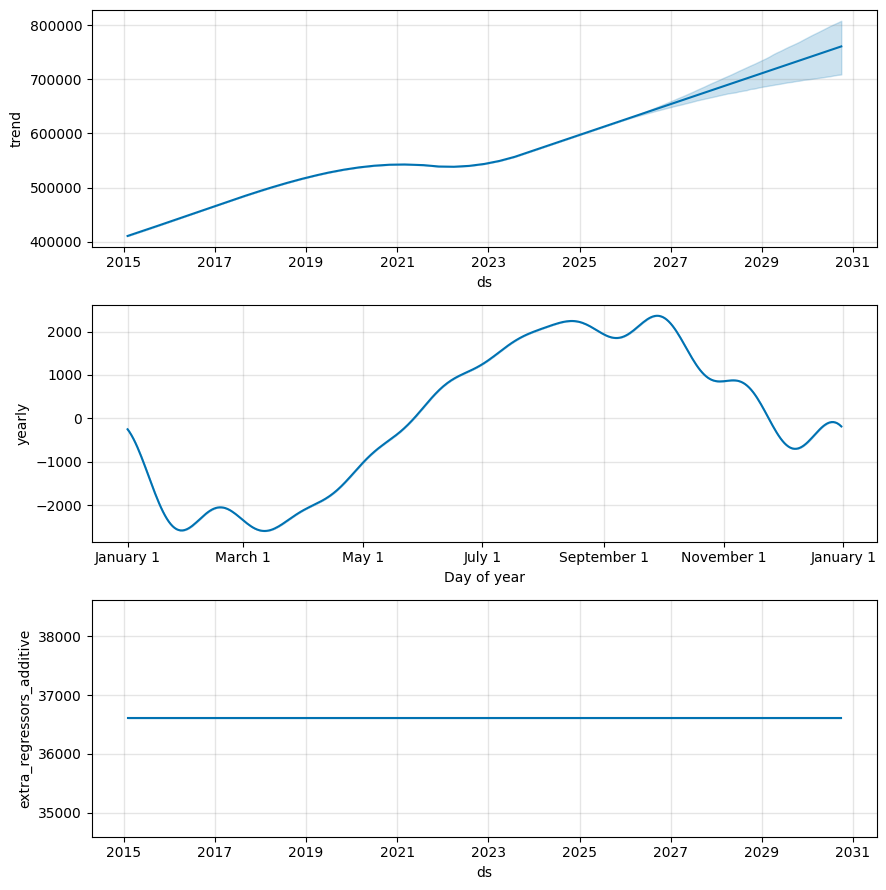

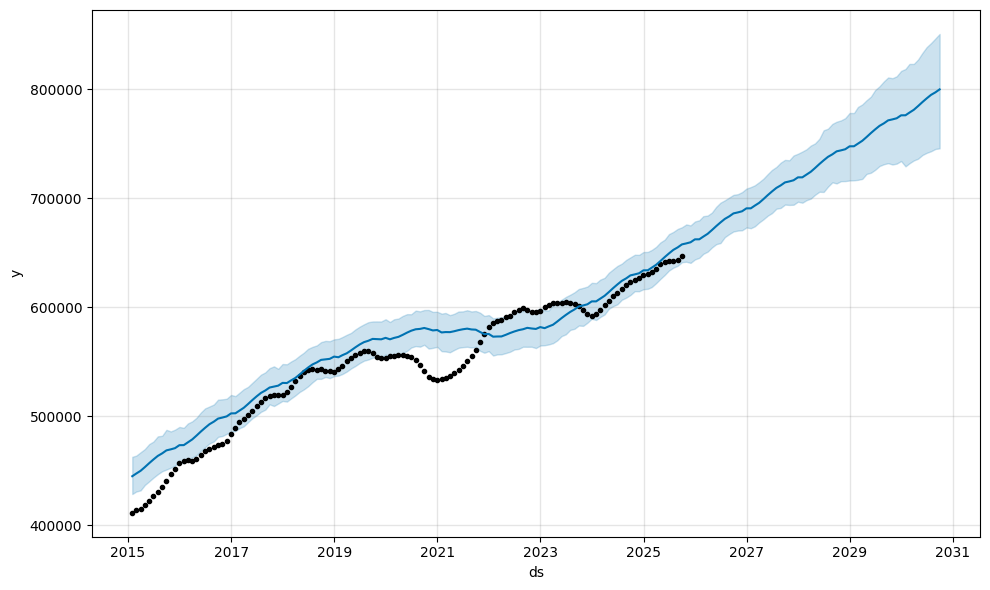

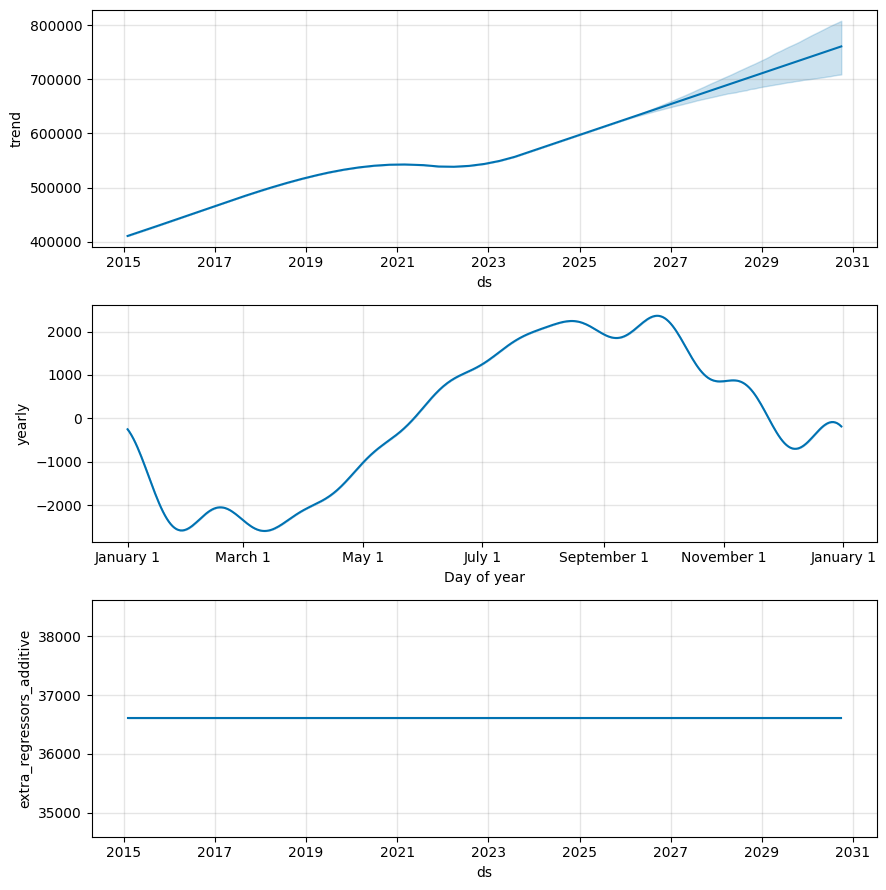

In [421]:
m.plot(forecast)
m.plot_components(forecast)


#### **Run Prophet for ALL counties**

In [422]:
# Prepare Prophet-ready data
prophet_df = county_merged[[
    "County", "PriceDate", "HomePrice",
    "Mortgage Rate", "TaxAmount"
]].copy()

prophet_df = prophet_df.rename(columns={
    "PriceDate": "ds",
    "HomePrice": "y",
    "Mortgage Rate": "mortgage_rate",
    "TaxAmount": "tax"
})

prophet_df = prophet_df.dropna()
prophet_df = prophet_df.sort_values(["County", "ds"])

# Store forecasts for each county
county_forecasts = {}

counties = prophet_df["County"].unique()

for county in counties:
    df_c = prophet_df[prophet_df["County"] == county]

    if len(df_c) < 24:
        continue  # Not enough data

    m = Prophet()
    m.add_regressor("mortgage_rate")
    m.add_regressor("tax")

    m.fit(df_c)

    # Create future dates
    future = m.make_future_dataframe(periods=60, freq="M")

    # Use last known values for regressors
    future["mortgage_rate"] = df_c["mortgage_rate"].iloc[-1]
    future["tax"] = df_c["tax"].iloc[-1]

    forecast = m.predict(future)
    forecast["County"] = county

    county_forecasts[county] = forecast

print("Done forecasting all counties!")


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local

Done forecasting all counties!


#### **Predict rent for 2025–2030**

In [424]:
rent_growth = 0.025  # we don’t have historical rent so let's assume 2.5% annual rent inflation per year

rent_forecasts = []

for county in county_rent["County"].unique():
    base_rent = county_rent[county_rent["County"] == county]["MonthlyRent"].iloc[0]

    for year in range(2025, 2031):  # 2025-2030
        future_rent = base_rent * ((1 + rent_growth) ** (year - 2024))

        rent_forecasts.append({
            "County": county,
            "Year": year,
            "MonthlyRentForecast": future_rent
        })

rent_forecasts = pd.DataFrame(rent_forecasts)

rent_forecasts

,County,Year,MonthlyRentForecast
0,Albany,2025,1118.787500
1,Albany,2026,1146.757187
2,Albany,2027,1175.426117
3,Albany,2028,1204.811770
4,Albany,2029,1234.932064
...,...,...,...
367,Yates,2026,802.852604
368,Yates,2027,822.923919
369,Yates,2028,843.497017
370,Yates,2029,864.584443


#### **Export everything to CSV**
#### **5-year cost of renting vs 5-year cost of buying**

In [425]:
all_prophet = pd.concat(county_forecasts.values(), ignore_index=True)
all_prophet.to_csv("home_price_forecasts.csv", index=False)


In [426]:
rent_forecasts.to_csv("rent_forecasts.csv", index=False)


#### **Build the ML Model (Random Forest)**

In [428]:
ml_df = county_merged[[
    "HomePrice", "Mortgage Rate", "TaxAmount", "MonthlyRent", "Year"
]].dropna()

X = ml_df.drop(columns=["HomePrice"])
y = ml_df["HomePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor(n_estimators=300)
model.fit(X_train, y_train)

print("Model score:", model.score(X_test, y_test))

Model score: 0.9991202182910511


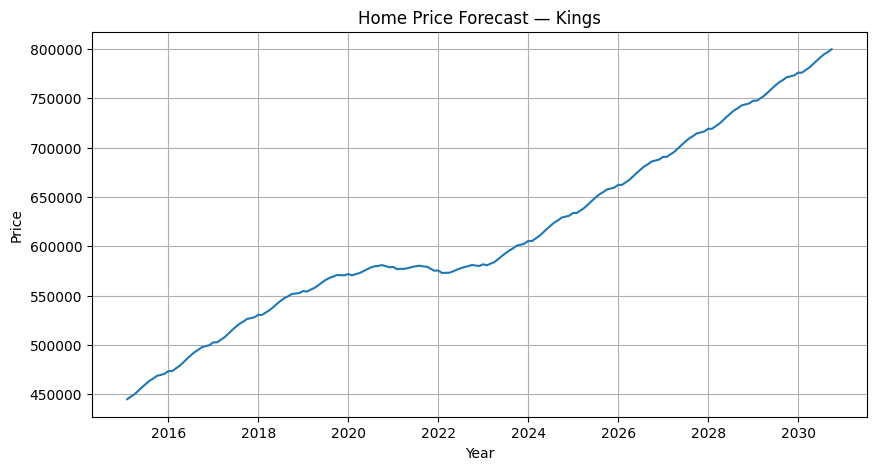

In [429]:
import matplotlib.pyplot as plt

county = "Kings"

df_plot = all_prophet[all_prophet["County"] == county]

plt.figure(figsize=(10,5))
plt.plot(df_plot["ds"], df_plot["yhat"])
plt.title(f"Home Price Forecast — {county}")
plt.ylabel("Price")
plt.xlabel("Year")
plt.grid(True)
plt.show()


#### **Just Check the data, we can delete it**

In [430]:
county_merged.head(20)


,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,PriceDate,HomePrice,County,Year,Month,TaxAmount,TaxDate,Mortgage Rate,RentDate,Housing,MonthlyRent
0,581,6,Kings County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,47,2000-01-31,117798.487679,Kings,2000,2000-01-31,NaN,NaT,NaN,2024-01-01,26251.0,2187.583333
1,1347,10,Queens County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,81,2000-01-31,117354.466108,Queens,2000,2000-01-31,NaN,NaT,NaN,2024-01-01,28178.0,2348.166667
2,2452,20,New York County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,61,2000-01-31,258182.439226,New York,2000,2000-01-31,NaN,NaT,NaN,2024-01-01,31371.0,2614.250000
3,2046,24,Suffolk County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,103,2000-01-31,91291.879450,Suffolk,2000,2000-01-31,NaN,NaT,NaN,2024-01-01,22245.0,1853.750000
4,401,26,Bronx County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,5,2000-01-31,81662.035485,Bronx,2000,2000-01-31,NaN,NaT,NaN,2024-01-01,21130.0,1760.833333
5,1252,29,Nassau County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,59,2000-01-31,131162.307959,Nassau,2000,2000-01-31,NaN,NaT,NaN,2024-01-01,22295.0,1857.916667
6,3148,48,Westchester County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,119,2000-01-31,114825.799481,Westchester,2000,2000-01-31,NaN,NaT,NaN,2024-01-01,27604.0,2300.333333
7,157,55,Erie County,county,NY,NY,"Buffalo-Cheektowaga, NY",36,29,2000-01-31,54579.383567,Erie,2000,2000-01-31,NaN,NaT,NaN,2024-01-01,12016.0,1001.333333
8,1223,87,Monroe County,county,NY,NY,"Rochester, NY",36,55,2000-01-31,57213.173289,Monroe,2000,2000-01-31,NaN,NaT,NaN,2024-01-01,12754.0,1062.833333
9,2511,143,Richmond County,county,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",36,85,2000-01-31,111612.221545,Richmond,2000,2000-01-31,NaN,NaT,NaN,2024-01-01,24853.0,2071.083333


In [431]:
county_merged.tail(20)


,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,PriceDate,HomePrice,County,Year,Month,TaxAmount,TaxDate,Mortgage Rate,RentDate,Housing,MonthlyRent
15847,1630,715,Clinton County,county,NY,NY,"Plattsburgh, NY",36,19,2025-09-30,131762.195956,Clinton,2025,2025-09-30,2341.0,2025-01-01,6.3525,2024-01-01,11387.0,948.916667
15848,3088,732,Cattaraugus County,county,NY,NY,"Olean, NY",36,9,2025-09-30,124117.196275,Cattaraugus,2025,2025-09-30,2054.0,2025-01-01,6.3525,2024-01-01,8833.0,736.083333
15849,929,738,Cayuga County,county,NY,NY,"Auburn, NY",36,11,2025-09-30,179549.977339,Cayuga,2025,2025-09-30,2550.0,2025-01-01,6.3525,2024-01-01,9881.0,823.416667
15850,1909,790,Madison County,county,NY,NY,"Syracuse, NY",36,53,2025-09-30,159390.136985,Madison,2025,2025-09-30,2766.0,2025-01-01,6.3525,2024-01-01,10073.0,839.416667
15851,1479,827,Warren County,county,NY,NY,"Glens Falls, NY",36,113,2025-09-30,207548.197830,Warren,2025,2025-09-30,2525.0,2025-01-01,6.3525,2024-01-01,13045.0,1087.083333
15852,2961,861,Livingston County,county,NY,NY,"Rochester, NY",36,51,2025-09-30,157235.519704,Livingston,2025,2025-09-30,3062.0,2025-01-01,6.3525,2024-01-01,10330.0,860.833333
15853,2214,869,Columbia County,county,NY,NY,"Hudson, NY",36,21,2025-09-30,318202.333871,Columbia,2025,2025-09-30,3605.0,2025-01-01,6.3525,2024-01-01,14111.0,1175.916667
15854,3066,870,Washington County,county,NY,NY,"Glens Falls, NY",36,115,2025-09-30,172526.672478,Washington,2025,2025-09-30,2875.0,2025-01-01,6.3525,2024-01-01,11979.0,998.250000
15855,2340,878,Herkimer County,county,NY,NY,"Utica-Rome, NY",36,43,2025-09-30,139757.371779,Herkimer,2025,2025-09-30,2097.0,2025-01-01,6.3525,2024-01-01,10067.0,838.916667
15856,1298,890,Otsego County,county,NY,NY,"Oneonta, NY",36,77,2025-09-30,139482.683735,Otsego,2025,2025-09-30,2053.0,2025-01-01,6.3525,2024-01-01,9785.0,815.416667


In [432]:
county_merged.columns


Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS', 'PriceDate',
       'HomePrice', 'County', 'Year', 'Month', 'TaxAmount', 'TaxDate',
       'Mortgage Rate', 'RentDate', 'Housing', 'MonthlyRent'],
      dtype='object')

In [433]:
county_merged.isna().sum()


,0
RegionID,0
SizeRank,0
RegionName,0
RegionType,0
StateName,0
State,0
Metro,0
StateCodeFIPS,0
MunicipalCodeFIPS,0
PriceDate,0


In [434]:
county_merged.columns.duplicated().sum()


np.int64(0)

In [435]:
county_merged.duplicated().sum()


np.int64(0)